# 2-level system with oscillating detuning

## Imports
Start by importing the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Define states
We start by defining the two states of the system: the ground state $|g\rangle$ and the excited $|e\rangle$.

In [2]:
g = BasisState(qn=ToyQuantumNumbers(label="g"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Print the states as a check
print(f"|g> = {g}")
print(f"|e> = {e}")

# Check that the states are orthogonal by taking inner product
print(f"<e|g> = {e @ g}")

|g> = |g>
|e> = |e>
<e|g> = 0


## Define basis
We use the two orthogonal states to define a basis as shown below. The indexing of the matrix and vector representations of operators is determined by the order of the states when generating the state

In [3]:
basis = Basis((g,e))
basis.print()

|0> = |g>
|1> = |e>


## Define energies
I'm going to define the system in the rotating frame so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$. The detuning between the driving field and the natural frequency of the system is taken to be $ \Delta(t) = \Delta_0 + \frac{A}{2}\sin(\omega t) $.

In [4]:
E_g = ToyEnergy([g], 1, time_dep = "Delta0/2 +  A/2 * sin(omega*t)", time_args = {"Delta0":0, "omega":5, "A":1}) 
E_e = ToyEnergy([e], 1,  time_dep = "-Delta0/2 - A/2 * sin(omega*t)", time_args = {"Delta0":0, "omega":5, "A":1})

### Define coupling
Take the coupling field between the two states to be constant

In [5]:
Ω = Symbol('Omega') 
coupling = ToyCoupling(g, e, Ω/2)

## Define Hamiltonian
Now that we have the states, energies and couplings, we can define the Hamiltonian

In [6]:
H = Hamiltonian((E_g, E_e, coupling), basis)
display(H)

H =
[
[1.0, 0.5],
[0.5, 1.0]]

in basis Basis: name = None

## Define a QuantumSystem
The QuantumSystem object combines the basis, decays, and Hamiltonian to make setting parameters for time evolution using QuTiP more convenient.

In [7]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E_g, E_e, coupling],
    decays = []
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

In [8]:
for _ in Hqobj.ops:
    print(_.coeff)
    print(_.qobj)
    print("="*80)

Delta0/2 +  A/2 * sin(omega*t)
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]
-Delta0/2 - A/2 * sin(omega*t)
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]
Omega
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.  0.5]
 [0.5 0. ]]


In [12]:
from julia import Main
def init_julia():
    import julia
    Main.eval("""
    using ModelingToolkit
    using DifferentialEquations

    indexof(sym,syms) = findfirst(isequal(sym),syms)

    function prob_func_factory(var, scan, system)
        function prob_func(prob, i, repeat)
            pnew = copy(prob.p)
            pnew[indexof(var, parameters(system))] = scan[i]
            remake(prob, p=pnew)
        end
        return prob_func
    end
    """)

In [175]:
from dataclasses import dataclass, field

class ODEParameters:
    def __init__(self, parameters, parameters_name = 'p'):
        self.icomplex = 1j
        self._parameters = [key for key in parameters.keys()]
        self._parameters.append('icomplex')
        self._parameters = tuple(self._parameters)
        for key, val in parameters.items():
            setattr(self, key, val)
        self.parameters_name = parameters_name
    
    def __repr__(self,):
        rep = "OdeParameters("
        for par in self._parameters:
            if par == 'icomplex':
                continue
            rep += f"{par}={getattr(self, par)}, "
        return rep.strip(", ") + ")"
    
    def generate_p_julia(self):
        parameters = [f"{par} => {getattr(self, par)}" for par in self._parameters]
        parameters[parameters.index('icomplex => 1j')] = "icomplex => 1im"
        Main.eval(f"""
            {self.parameters_name} = [{','.join(parameters)}]
            _ = nothing
        """)

class System:
    def __init__(self, system_name, Hqobj):
        self.name = system_name
        self.Hqobj = Hqobj
        self.parameters = list(Hqobj.args.keys())
        self.size = Hqobj.ops[0].qobj.data.shape[0]
        
        self.instructions = []
        self._generate_system()
        
    def __repr__(self,):
        return f"System({self.name})"
        
    def _generate_system(self):
        instructions = []
        instructions.append(f"@parameters {' '.join(self.parameters)} icomplex")
        instructions.append(f"@variables t ρ[1:{self.size}, 1:{self.size}](t) H[1:{self.size},1:{self.size}](t)")
        instructions.append("D = Differential(t)")
        instructions.append("eq = -icomplex * Symbolics.scalarize(H*ρ-ρ*H)")
        
        
        instructions.append("eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:size(H)[1] for idy in 1:size(H)[2]]")
        
        entries = [(i,j) for i in range(self.size) for j in range(self.size)]
        for op in self.Hqobj.ops:
            for i,j in zip(*np.nonzero(op.qobj)):
                val = op.qobj[i,j]
                val = f"({val.real} + {val.imag}im)"
                instructions.append(f"append!(eqns, [H[{i+1},{j+1}] ~ {val}*({op.coeff})])")
                entries.remove((i,j))
        for i,j in entries:
            entries.remove((i,j))
            instructions.append(f"append!(eqns, [H[{i+1},{j+1}] ~ 0])")
            
        instructions.append(f"@named {self.name} = ODESystem(eqns)")
        instructions.append(f"{self.name} = structural_simplify({self.name})")
        instruct = "\n".join(instructions)
        Main.eval(f"""
        {instruct}
        _ = nothing
        """)
        self.instructions = instructions
        
class InitialDensity:
    def __init__(self, initial_density, density_name = 'u0'):
        self.density_name = density_name
        self.initial_density = initial_density
        self._generate_initial_density()
    
    def __repr__(self,):
        return "InitialDensity()"
    
    def _generate_initial_density(self,):
        setattr(Main, f"{self.density_name}_mat", self.initial_density)
        Main.eval(f"""
        {self.density_name} = [ρ[idx,idy] => {self.density_name}_mat[idx,idy] for idx in 1:size(H)[1] for idy in 1:size(H)[2]]
        _ = nothing
        """)
    
class ODEProblem:
    def __init__(self, problem_name, timespan, system, odeparameters, initial_density):
        self.name = problem_name
        self.system_name = system.name
        self.parameters_name = odeparameters.parameters_name
        self.density_name = initial_density.density_name
        self.timespan = timespan
        self.size = system.size
        odeparameters.generate_p_julia()
        self._generate_problem()
        
    def __repr__(self,):
        return f"ODEProblem({self.name})"
        
    def _generate_problem(self):
        Main.eval(f"""
            {self.name} = ODEProblem({self.system_name}, {self.density_name}, {self.timespan}, {self.parameters_name}, jac = true)
        """)

class ODESolution:
    def __init__(self, solution_name, problem_name, size):
        self.solution_name = solution_name
        self.problem_name = problem_name
        self.size = size
        
        self.t = None
        self.result = None
        self._get_data()
        
    def __repr__(self,):
        return f"ODESolution({self.solution_name}, {self.problem_name})"
        
    def _get_data(self):
        self.t = Main.eval(f"{self.solution_name}.t")
        self.sol = np.asarray(Main.eval(f"{self.solution_name}.u"))
        self.sol = self.sol.reshape(-1, self.size, self.size)
        self.sol = np.array([val for val in self.sol])
    
    def get_parameter(self, parameter):
        return np.array(Main.eval(f"sol[{parameter}]"))
        
    def get_expect(self, operator):
        return np.trace(self.sol@np.asarray(operator), axis1 = 1, axis2 = 2)
    
@dataclass
class SolverOptions:
    method: str = "Tsit5()"
    abstol: float = 1e-8
    reltol: float = 1e-8
    dtmax: float = 1.0
    saveat: float = field(default_factory=list)
    tstops: list = field(default_factory=list)
    save_everystep: bool = True

    def generate_kwargs(self):
        kwargs = {}
        for key in self.__dataclass_fields__.keys():
            val = getattr(self, key)
            if isinstance(val, bool):
                kwargs[key] = str(val).lower()
            elif val is None:
                kwargs[key] = 'nothing'
            elif isinstance(val, list):
                if len(val) == 0:
                    kwargs[key] = '[]'
            else:
                kwargs[key] = val
        return kwargs
        
def solve(solution_name, problem, solver_options):
    sol_opts = f"{','.join([f'{key} = {val}' for key,val in solver_options.generate_kwargs().items()])}"
    sol_opts = sol_opts.replace("method = ", "")
    Main.eval(f"""
    {solution_name} = solve({problem.name}, {sol_opts})
    _ = nothing
    """)
    return ODESolution(solution_name, problem.name, problem.size)

class ODESolutionParameterScan:
    def __init__(self, solution_name, problem_name, size, parameters):
        self.solution_name = solution_name
        self.problem_name = problem_name
        self.size = size
        
        self.t = None
        self.sol = None
        
        self.parameters = parameters
        self.scanned_values = None
        
        self._get_data()
        

    def __repr__(self,):
        return f"ODESolutionParameterScan({self.solution_name}, {self.problem_name})"
    
    def _get_data(self):
        self.t = Main.eval(f"[u.t for u in {self.solution_name}.u]")
        self.sol = Main.eval(f"{self.solution_name}.u")
        self.sol = [np.array(arr) for arr in self.sol]
        self.sol = [arr.reshape(self.size, self.size, -1) for arr in self.sol]
        self.sol = [np.moveaxis(arr, -1, 0) for arr in self.sol]
        
        self.scanned_values = Main.scan

    def get_expect(self, idx, operator):
        return np.trace(self.sol[idx]@np.asarray(operator), axis1 = 1, axis2 = 2)
    
    def get_scan_values(self,idx):
        return dict([(par, self.scanned_values[idx][idp]) for idp, par in enumerate(self.parameters)])
        
@dataclass
class EnsembleSolverOptions:
    method: str = "Tsit5()"
    ensemble_method: str = "EnsembleThreads()"
    abstol: float = 1e-8
    reltol: float = 1e-8
    dtmax: float = 1.0
    saveat: float = field(default_factory=list)
    tstops: list = field(default_factory=list)
    save_everystep: bool = True
    save_start: bool = True

    def generate_kwargs(self):
        kwargs = {}
        for key in self.__dataclass_fields__.keys():
            val = getattr(self, key)
            if isinstance(val, bool):
                kwargs[key] = str(val).lower()
            elif val is None:
                kwargs[key] = 'nothing'
            elif isinstance(val, list):
                if len(val) == 0:
                    kwargs[key] = '[]'
            else:
                kwargs[key] = val
        return kwargs
    
def parameter_scan_prob_func(parameters, problem):
    indices_julia = [
        Main.eval(f"indexof({parameter}, parameters({problem.system_name}))") 
        for parameter in parameters
    ]
    nparameters = Main.eval(f"size(parameters({problem.system_name}))[1]")
    if len(parameters) == 1:
        pchange = f"pnew[{indices_julia[0]}] = scan[i]"
    else:
        pchange = ""
        for ids,idx in enumerate(indices_julia):
            pchange += f"pnew[{idx}] = scan[i,{ids+1}]\n"
    prob_func = f"""function prob_func(prob, i, repeat)
        pnew = copy({problem.name}.p)
        {pchange}
        remake({problem.name}, p=pnew)
    end
    """
    Main.eval(prob_func)
    
def solve_single_parameter_scan(solution_name, problem, solver_options, parameters, values):
    sol_opts = f"{','.join([f'{key} = {val}' for key,val in solver_options.generate_kwargs().items()])}"
    sol_opts = sol_opts.replace("ensemble_method = ", "").replace("method = ", "")
    parameter_scan_prob_func(parameters, problem)
    if len(values) == 1:
        Main.scan = values[0]
    else:
        Main.scan = np.array(np.meshgrid(*values)).T.reshape(-1, len(values))
    Main.eval(f"""
    ens_{problem.name} = EnsembleProblem({problem.name}, prob_func = prob_func)
    {solution_name} = solve(ens_{problem.name}, {sol_opts}, trajectories = size(scan)[1])
    _ = nothing
    """)
    return ODESolutionParameterScan(solution_name, problem.name, problem.size, parameters)

In [176]:
ρ0 = np.zeros([2,2], dtype = complex)
ρ0[0,0] = 1

init_julia()
system = System("system", Hqobj)
odepars = ODEParameters(Hqobj.args)
odepars.omega = 15.
initial_density = InitialDensity(ρ0)
problem = ODEProblem('prob', (-18.85, 18.85), system, odepars, initial_density)

In [177]:
solver_options = SolverOptions(method = 'Tsit5()', dtmax = 0.1)
solution = solve("sol", problem, solver_options)

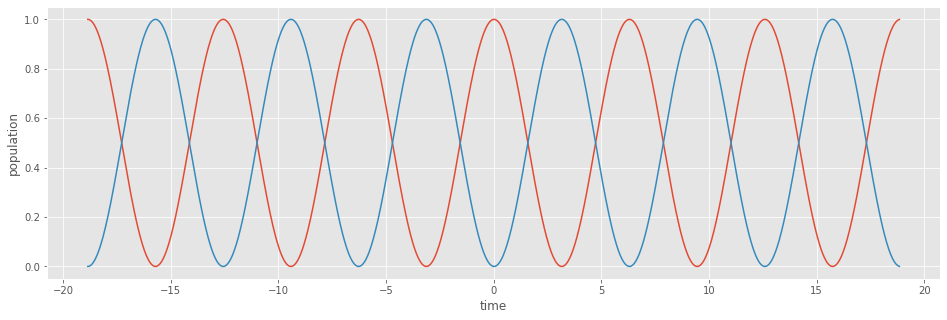

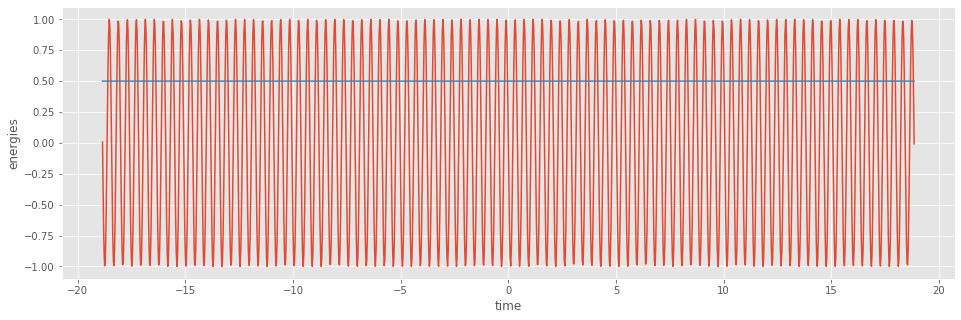

In [178]:
fig, ax = plt.subplots(figsize = (16,5))

ax.plot(solution.t, solution.get_parameter("ρ[1,1]").real)
ax.plot(solution.t, solution.get_parameter("ρ[2,2]").real)

ax.set_xlabel("time")
ax.set_ylabel("population")

fig, ax = plt.subplots(figsize = (16,5))

ax.plot(solution.t, solution.get_parameter("H[2,2]").real - solution.get_parameter("H[1,1]").real)
ax.plot(solution.t, solution.get_parameter("H[1,2]").real)

ax.set_xlabel("time")
ax.set_ylabel("energies");

In [188]:
ens_solver_options = EnsembleSolverOptions(method = 'Tsit5()', ensemble_method='EnsembleThreads()', dtmax = 0.1, save_everystep=True, save_start = True)
solution = solve_single_parameter_scan("ens_sol", problem, ens_solver_options, ['Omega', 'omega'], [np.linspace(0,3,11), np.linspace(0,15,101)])

{'Omega': 0.6, 'omega': 7.199999999999999}

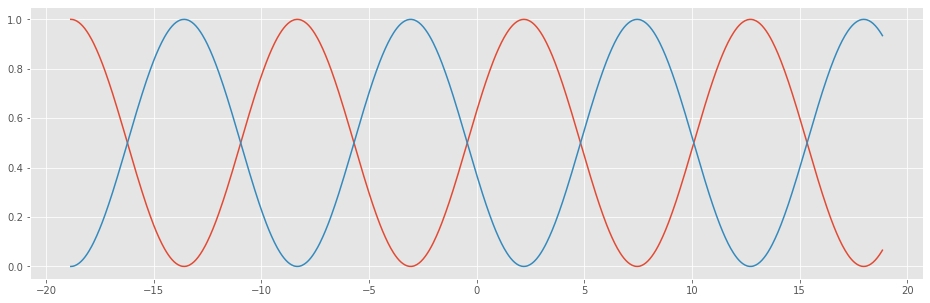

In [192]:
idx = 250
fig, ax = plt.subplots(figsize = (16,5))

ax.plot(solution.t[idx], solution.sol[idx][:,0,0].real)
ax.plot(solution.t[idx], solution.sol[idx][:,1,1].real)
solution.get_scan_values(idx)

## Time-evolution using `QuTiP`
The `toy_systems` package is designed to take care of generating the Hamiltonian and collapse operators for the quantum system, and spit out a `qutip.QobjEVo`-object. The actual time-evolution is then taken care of by `qutip` (or something else if the user so desires).

In [497]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'Delta0': 0, 'omega': 15, 'A': 10, 'Omega': 1}


In [701]:
odepars

OdeParameters(Delta0=0, omega=15, A=10, Omega=1)

In [739]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Pauli matrices for calculating components of Bloch vector
sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()


# Set the parameters for the system
args["Omega"] = 1 # The maximum value of the drive field Rabi rate (set to one so can use 1/Omega as unit of time)
args["Delta0"] = 0 # Constant part of detuning
args["A"] = 10 # Amplitude of detuning oscillations
args["omega"] = 0 # Frequency of detuning oscillations

# Times at which result is requested
times = np.linspace(-3/np.abs(args["Omega"]), 3/np.abs(args["Omega"]), 3001) * 2* np.pi

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e0/np.abs(args["omega"]),)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = [P_g_op, P_e_op, sx, sy, sz],
                      progress_bar=pb, options = options)

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

C:\Users\ogras\AppData\Local\Temp\ipykernel_27912\1959900773.py:25: RuntimeWarning: divide by zero encountered in true_divide
  options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e0/np.abs(args["omega"]),)


 Total run time:   2.71s*] Elapsed 2.71s / Remaining 00:00:00:00[****     16%           ] Elapsed 0.42s / Remaining 00:00:00:02[*********91%*********  ] Elapsed 2.47s / Remaining 00:00:00:00[*********94%********** ] Elapsed 2.55s / Remaining 00:00:00:00


Plot the result:

Text(0, 0.5, 'Rabi rate')

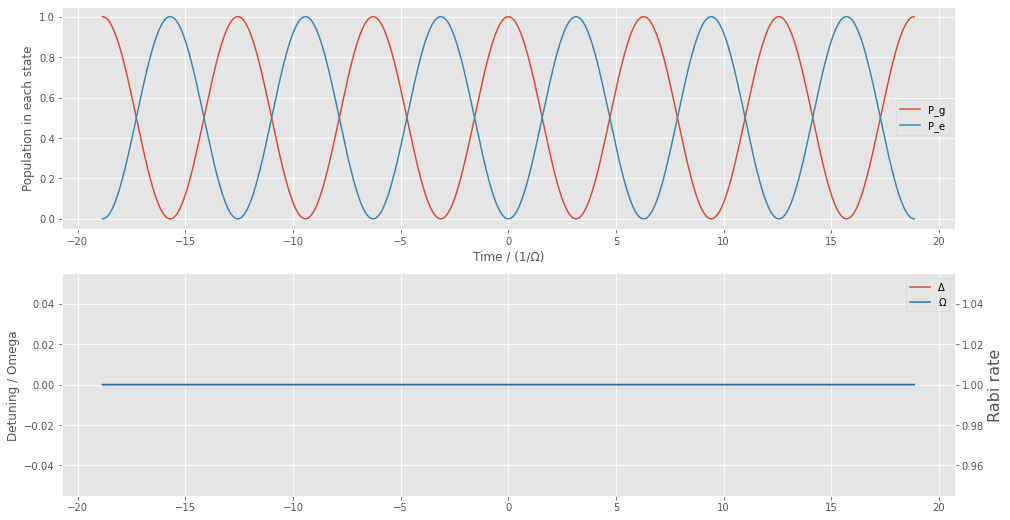

In [718]:
fig, (ax,ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

# Plot the coupling strength and detuning also
ax2c = ax2.twinx()
ln1 = ax2.plot(times, E_e.eval(times, args) - E_g.eval(times, args) , label = "Δ")
ax2.set_ylabel('Detuning / Omega')
ln2 = coupling.plot_time_dep(times, args, ax = ax2c, label = 'Ω', c = 'tab:blue')
ax2c.grid(False)
ax2c.set_ylabel('')
ax2.legend(ln1+ln2, [l.get_label() for l in (ln1 + ln2)])
ax2c.set_ylabel('Rabi rate')

### Visualizing on Bloch sphere

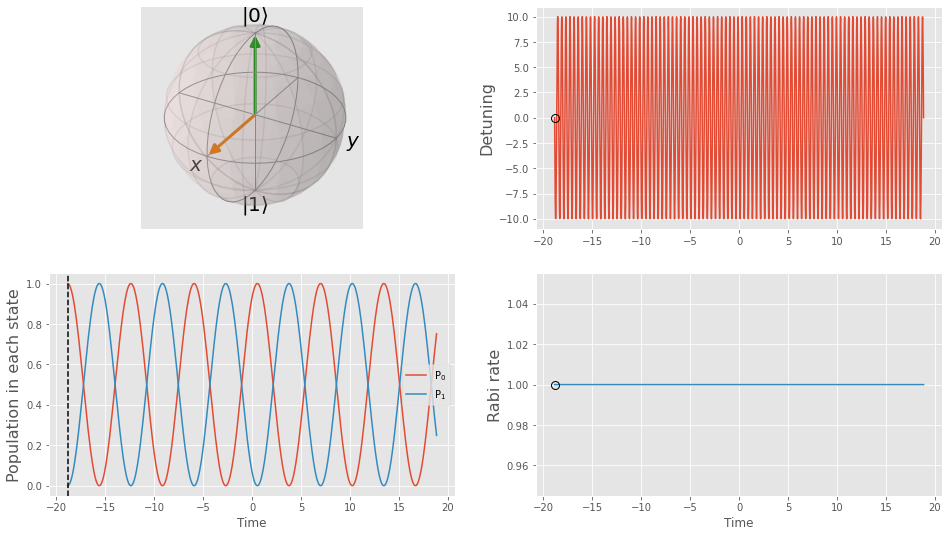

In [11]:
# Calculate components of Bloch vector
u = -result.expect[2]
v = result.expect[3]
w = result.expect[4]

# Calculate detuning and coupling strength
deltas = E_e.eval(times, time_args=args) - E_g.eval(times, time_args=args) 
Omegas = coupling.eval(times, time_args=args)
W_length = np.sqrt(deltas**2 + Omegas**2)


# Set up the bloch sphere
fig = plt.figure(figsize = (16, 9))
ax0 = fig.add_subplot(221, projection = '3d')
ax0.set_title('Bloch sphere', fontsize = 18)
b = qutip.Bloch(fig = fig, axes = ax0)
b.frame_width = 1
b.figsize = (16,16)

# Add initial Bloch vector and Rabi vector
b.add_vectors([np.array([u[0],v[0],w[0]]), np.array([Omegas[0], 0, deltas[0]])])
b.make_sphere()

# Set up plot of detuning 
ax1 = fig.add_subplot(222)
ax1.plot(times, deltas, label = "Δ")
ax1.set_ylabel('Detuning', fontsize = 16)
delta_marker = ax1.plot(times[0], deltas[0], marker = 'o', markersize=8, c = 'k', fillstyle='none')

# Set up plot of Rabi rate
ax2 = fig.add_subplot(224)
ax2.plot(times, Omegas, label = "Ω", c = 'C1')
ax2.set_ylabel('Rabi rate', fontsize = 16)
ax2.set_xlabel('Time')
rabi_marker = ax2.plot(times[0], Omegas[0], marker = 'o', markersize=8, c = 'k', fillstyle='none')

# Set up plot of populations
ax3 = fig.add_subplot(223)
ax3.plot(times, result.expect[0], label = r"P$_0$")
ax3.plot(times, result.expect[1], label = r"P$_1$")
ax3.set_ylabel('Population in each state', fontsize = 16)
vline = ax3.axvline(times[0], ls = '--', c = 'k')
ax3.set_xlabel('Time')
ax3.legend()


# Define function that generates frames for animation
def animate(i):
    b.clear()
    b.add_vectors([np.array([u[i],v[i],w[i]]), np.array([Omegas[i], 0, deltas[i]])/W_length[i]])
    i_start = np.max([0, i-100])
    b.add_points([u[i_start:i+1],v[i_start:i+1],w[i_start:i+1]])
    b.make_sphere()
    
    ax1.lines[1].remove()
    ax1.plot(times[i], deltas[i], marker = 'o', markersize=8, c = 'k', fillstyle='none')
    
    ax2.lines[1].remove()
    ax2.plot(times[i], Omegas[i], marker = 'o', markersize=8, c = 'k', fillstyle='none')
    
    ax3.lines[2].remove()
    ax3.axvline(times[i], ls = '--', c = 'k')


    return fig, (ax0, ax1, ax2, ax3)

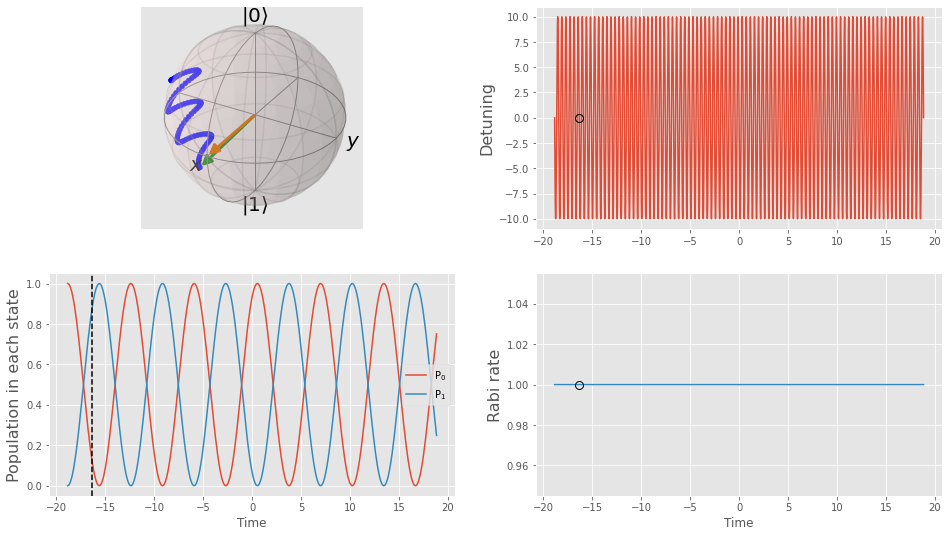

In [12]:
fig, _ = animate(200)
fig

In [13]:
# %%timeit
ani = animation.FuncAnimation(fig, animate, range(0,len(times),3), blit=False, repeat=False)
ani.save(f"oscillating_detuning_Delta0={args['Delta0']:.1f}_A={args['A']:.1f}_omega={args['omega']:.1f}.mp4", fps = 60)

ValueError: unknown file extension: .mp4